# Proyecto intermedio

Daniel Silva Contreras

In [151]:
import numpy as np
import gym
import gym_minigrid

In [152]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Prueba 1: cargar el ambiente y realizar una acción

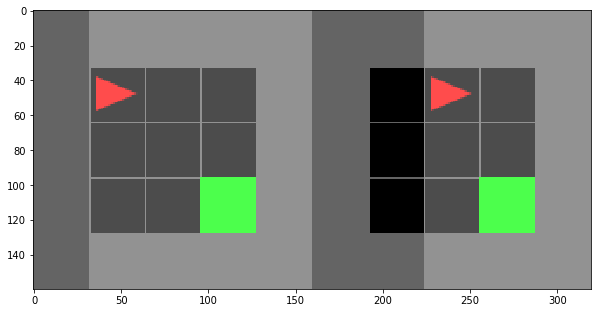

In [153]:
env = gym.make('MiniGrid-Empty-5x5-v0')
env.reset()
before_img = env.render('rgb_array')
action = env.actions.forward
obs, reward, done, info = env.step(action)
after_img = env.render('rgb_array')

plt.imshow(np.concatenate([before_img, after_img], 1));

Prueba 2: visualizar datos de regreso del ambiente

Observation: {'image': array([[[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]]], dtype=uint8), 'direction': 1, 'm

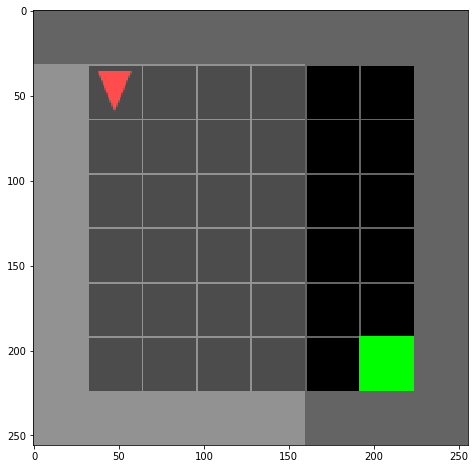

In [154]:
env = gym.make('MiniGrid-Empty-8x8-v0')
env.reset()
action = env.actions.right
obs, reward, done, info = env.step(action)
img = env.render('rgb_array')

print('Observation:', obs)
print('Reward:', reward)
print('Done:', done)
print('Info:', info)
print('Image shape:', img.shape)
plt.imshow(img);

Función para obtener el estado en términos de los ID de los objetos observables

In [155]:
#Regresa el estado observable expresado como los ID de los objetos
#Regresa el ID y key del objeto que tiene enfrente el agente.
def conv_state(state):
    col=[];row=[]
    for c in state:
        col=[]
        for r in c:
            obj=r[0]
            col.append(obj)
        row.append(col)
    front_obj = row[3][5]
    state=front_obj
    obj_str=list(gym_minigrid.minigrid.OBJECT_TO_IDX.keys())[front_obj]
    return row,state,obj_str

In [156]:
#Regresa el estado observable expresado como la ocupación de las casillas
#Regresa el ID y key del objeto que tiene enfrente el agente.
def conv_state2(state):
    col=[];row=[]
    for c in state:
        col=[]
        for r in c:
            obj=r[0]
            col.append(obj)
        row.append(col)
    front_obj = row[3][5]
    right_obj = row[4][6]
    left_obj = row[2][6]
    d1=1 if (left_obj!=1)else 0
    d2=1 if (front_obj!=1)else 0
    d3=1 if (right_obj!=1)else 0
    state = d3*(2^2) + d2*(2^1) + d1*(2^0)
    obj_str=list(gym_minigrid.minigrid.OBJECT_TO_IDX.keys())[front_obj]
    return row,state,obj_str

Front ID: 1   Str: empty
Left: 1 Front: 1 Right 2 Sum: 4


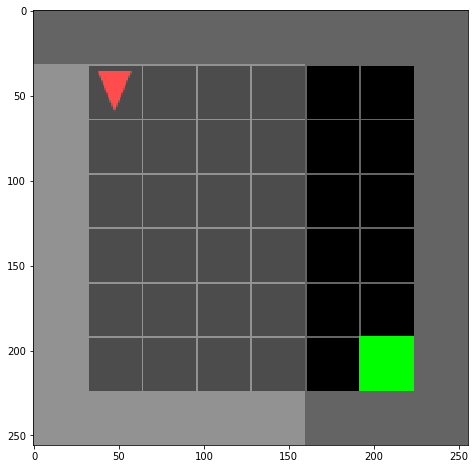

In [157]:
# Test data order
env.reset()      
action = env.actions.right
obs, reward, done, info = env.step(action)

img = env.render('rgb_array')
plt.imshow(img)

obs_img=obs['image']
obs_dir=obs['direction']

new_state, front, frontStr = conv_state2(obs_img)
front_obj = new_state[3][5]
right_obj = new_state[4][6]
left_obj = new_state[2][6]
sum_obj = left_obj + front_obj + right_obj
print("Front ID:",front_obj,"  Str:",frontStr)
print("Left:",left_obj,"Front:",front_obj,"Right",right_obj,"Sum:",sum_obj)


Q-learning Test

In [158]:
import numpy as np
import gym
import gym_minigrid
import random
import time
from IPython.display import clear_output

In [159]:
env = gym.make('MiniGrid-Empty-8x8-v0')

In [160]:
action_space_size = env.action_space.n
# state_space_size = env.observation_space.spaces['image'].shape
#action_space_size = 3
state_space_size = 30 # considera las dos representaciones de estados consideradas arriba
print("Action space size:",action_space_size,"\nState  space size:",state_space_size)
q_table=np.zeros((state_space_size,action_space_size))
print(q_table.shape)

Action space size: 7 
State  space size: 30
(30, 7)


In [161]:
num_episodes=10000
max_steps_per_episode=100
learning_rate=0.1
discount_rate=0.98

In [162]:
def search_hall(state):
    # Revisa si hay pasillos
    hall_v=[]
    hall_h=[]
    s=np.array(state)
    count_hallsv = np.count_nonzero(s==1,axis=1)
    count_hallsh = np.count_nonzero(s==1,axis=0)
    for element in count_hallsv:
        if (element==1):
            i=np.where(count_hallsv==element)[0][0]
            j=np.where(s[i]==element)[0][0]
            if(6 > i > 0):
                hall_v=[i,j]
            break
    for element in count_hallsh:
        if (element==1):
            i=np.where(count_hallsh==element)[0][0]
            j=np.where(s[:,i]==element)[0][0]
            if(6 > j > 0):
                hall_h=[j,i] # están al revés para traducirlo al marco coordenado del agente
            break         
    return hall_v, hall_h 

In [163]:
def distance_hall(old_hall,new_hall):
    distances=[-100,-100]
    for element in old_hall:
        dist=-1
        if(element!=[]):
            x1=element[0]
            y1=element[1]
            i=old_hall.index(element)
            if (new_hall[i]!=[]):
                x2=new_hall[i][0]
                y2=new_hall[i][1]
                dist=(x2-x1)+(y2-y1)
            else:
                dist=0 # perdió de vista el pasillo
            distances[i]=dist
        else:
            i=old_hall.index(element)
            if(new_hall[i]!=[]):
                distances[i]=10 #pasillo encontrado
    return distances

In [164]:
def isGoalpresent(state):
    s=np.array(state)
    result=np.where(s==8)
    if(result[0].size > 0):
        present=True
    else:
        present=False
    return present

In [165]:
def fun_reward(last_state, current_state, action, creward):
    USE_HALL_CONDITION=False
    USE_THREE_POSITION=True
    actionObject=0
    d_reward=0
    p_reward=0
    goal_present=isGoalpresent(current_state)
    
    # Restringe acciones
    in_obj=current_state[3][6] # Objeto sobre el que se encuentra el agente
    if (in_obj==0 or in_obj==1 or in_obj==3 or in_obj==8) and (action>=3 and action<=5): 
        actionObject=-20
    elif (in_obj==8 and action==6):
        actionObject=0.5
    elif (in_obj!=8 and action==6):
        actionObject=-30
        
    # usa una representación de lo que tiene el agente a la izquierda y derecha
    if (USE_THREE_POSITION==True):
        left_pos=current_state[2][6]
        front_pos=current_state[3][5]
        right_pos=current_state[4][6]
        if(right_pos!=1 and left_pos!=1 and front_pos==1):# pasillo
            p_reward = 0
        elif(right_pos!=1 and left_pos!=1 and front_pos!=1 and front_pos!=8): #sin salida
            p_reward = -0.2
        elif(front_pos==6 or front_pos==9 or front_pos==10): # ball or lava or other agent
            p_reward = -0.3
        else:
            p_reward = 0 #camino libre u obstruido por un costado
            
    # Pasillos
    if ((goal_present==False) and (USE_HALL_CONDITION==True)):
        last_hall=search_hall(last_state)
        current_hall=search_hall(current_state)
        hall_change=distance_hall(last_hall,current_hall)
        for d in hall_change:         
            if (d!=-100):
                if (d==10):
                    d_reward=0.1
                else:
                    d_reward+=d/100
    if (actionObject!=0):
        reward=actionObject
    else:
        reward=d_reward + p_reward
    return reward + creward
   

In [166]:
test_state=[[2, 1, 1, 1, 1, 1, 1], [2, 1, 1, 1, 1, 1, 1], [2, 1, 1, 1, 1, 1, 1], [2, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2]]
test_state2=[[2, 1, 1, 1, 1, 1, 1], [2, 1, 1, 1, 1, 1, 1], [2, 1, 1, 1, 1, 1, 1], [2, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2]]
goalp=isGoalpresent(test_state)
print(goalp)

False


In [168]:
def train_Q(env_name,num_episodes,max_steps,learning_rate,discount_rate,exploration_decay_rate):
    env = gym.make(env_name)
    action_space_size = env.action_space.n
    state_space_size = 30
    # print("Action space size:",action_space_size,"\nState  space size:",state_space_size)
    print("Training...\n")
    q_table=np.zeros((state_space_size,action_space_size))
    
    exploration_rate=1
    max_exploration_rate=1
    min_exploration_rate=0.01
    rewards_all_episodes=[]
    #Q learning algorithm
    convergence = False
    last=-1000
    for episode in range(num_episodes):
        completeState,state,stateStr=conv_state2(env.reset()['image'])
        last_state=completeState
        done = False
        rewards_current_episode = 0

        for step in range(max_steps):
            # Exploration-explotation trade-off
            exploration_rate_threshold=random.uniform(0,1)
            if exploration_rate_threshold > exploration_rate:
                action=np.argmax(q_table[state,:])
            else:
                action=env.action_space.sample()

            new_state,env_reward,done,info=env.step(action)
            completeState, newState, newStr=conv_state2(new_state['image'])
            
            reward = fun_reward(last_state,completeState,action,env_reward)
            
            # Update Q-table  for Q(s,a)
            q_table[state,action]=q_table[state,action] * (1- learning_rate) + \
            learning_rate*(reward+discount_rate*np.max(q_table[newState,:]))

            state=newState
            last_state=completeState
            rewards_current_episode+=reward
            if done==True:
                break
            # print("\r","Episode:{} Step:{}".format(episode,step),end="")
            

        exploration_rate=min_exploration_rate + \
            (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)
        rewards_all_episodes.append(rewards_current_episode)
        
        if(((episode+1) >= 1000) and ((episode+1) % 1000 == 0)):
            #Calculate and print the average reward per thousand episodes
            rewards_per_thousand_episodes= np.split(np.array(rewards_all_episodes),int((episode+1)/1000))
            
            avg=[]
            for r in rewards_per_thousand_episodes:
                avg.append(sum(r/1000))
            dif = abs(last-avg[len(avg)-1])
            if(dif <= 0.001):
                convergence = True
            last=avg[len(avg)-1]
            print("Episode",episode+1,":\tReward:{:.6f}\t".format(avg[len(avg)-1]),"Change: {:.5f}".format(dif))
                
        if (convergence == True):
            break
    print("\nDone\n")
    return q_table

In [117]:
q_table = train_Q(env_name = 'MiniGrid-Empty-8x8-v0',
                  num_episodes = 10000,
                  max_steps = 100,
                  learning_rate = 0.1,
                  discount_rate = 0.98,
                  exploration_decay_rate = 0.001)

Training...

Episode 1000 :	Reward:-668.976472	 Change: 331.02353
Episode 2000 :	Reward:-97.956911	 Change: 571.01956
Episode 3000 :	Reward:-21.611427	 Change: 76.34548
Episode 4000 :	Reward:-5.666272	 Change: 15.94515
Episode 5000 :	Reward:-2.132723	 Change: 3.53355
Episode 6000 :	Reward:-1.351771	 Change: 0.78095
Episode 7000 :	Reward:-0.782641	 Change: 0.56913
Episode 8000 :	Reward:-0.580307	 Change: 0.20233
Episode 9000 :	Reward:-0.351683	 Change: 0.22862
Episode 10000 :	Reward:-0.551582	 Change: 0.19990

Done



In [169]:
q_table2 = train_Q(env_name = 'MiniGrid-LavaCrossingS9N1-v0', #MiniGrid-LavaCrossingS9N3-v0
                  num_episodes = 10000,
                  max_steps = 100,
                  learning_rate = 0.1,
                  discount_rate = 0.98,
                  exploration_decay_rate = 0.001)

Training...

Episode 1000 :	Reward:-599.213000	 Change: 400.78700
Episode 2000 :	Reward:-254.950858	 Change: 344.26214
Episode 3000 :	Reward:-103.759200	 Change: 151.19166
Episode 4000 :	Reward:-46.443600	 Change: 57.31560
Episode 5000 :	Reward:-22.608442	 Change: 23.83516
Episode 6000 :	Reward:-15.598600	 Change: 7.00984
Episode 7000 :	Reward:-12.326900	 Change: 3.27170
Episode 8000 :	Reward:-10.513900	 Change: 1.81300
Episode 9000 :	Reward:-10.824500	 Change: 0.31060
Episode 10000 :	Reward:-10.238300	 Change: 0.58620

Done



In [170]:
# Test with the learned Q-table
%matplotlib inline
import matplotlib.animation as animation
from IPython.display import HTML

env_name='MiniGrid-LavaCrossingS9N1-v0'
#env_name='MiniGrid-Empty-8x8-v0'
env = gym.make(env_name)
TEST_STEPS = 100
cState, state, stateStr = conv_state2(env.reset()['image'])
images=[]
images.append(env.render('rgb_array'))
actions=[]

for step in range(TEST_STEPS):
    action=np.argmax(q_table2[state,:])
    actions.append(action)
    
    new_state,reward,done,info=env.step(action)
    cState, newState, newStr=conv_state2(new_state['image'])
    state=newState
    
    img = env.render('rgb_array')
    images.append(img)
    if done == True:
        break

fig = plt.figure(figsize=(10, 10))
ims = []
for i in range(len(images)):
    im = plt.imshow(images[i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat_delay=2000)
plt.close()
HTML(ani.to_html5_video())

In [120]:
ani.save('./video/empty8x8.mp4', writer='ffmpeg', fps=10, dpi=100)

In [173]:
case_Q = q_table2[]
print(case_Q)
print(np.argmax(case_Q))

[0. 0. 0. 0. 0. 0. 0.]
0


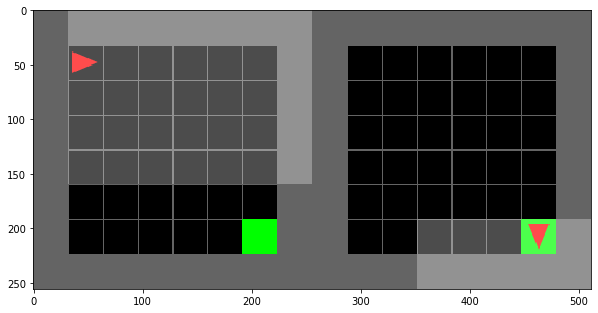

In [121]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.concatenate([images[0], images[len(images)-1]], 1));

In [171]:
print(actions)

[1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


Prueba con Keras

In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

In [105]:
env = gym.make('MiniGrid-Empty-8x8-v0')
env = gen_wrapped_env('MiniGrid-Empty-8x8-v0')
# np.random.seed(42), env.seed(42) 
nb_actions = env.action_space.n
input_shape = (1, env.observation_space.shape[0])

In [120]:
observation = env.reset()
for t in range(200):
    # img = env.render('rgb_array')
    # plt.imshow(img);
    act = env.action_space.sample()
    obs, rwrd, done, info = env.step(act)
    if done:
        print("Episode concluded after %i timesteps" % (t+1))
        break
env.close()

Episode concluded after 50 timesteps


In [113]:
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(12, activation='tanh'))
model.add(Dense(12, activation='tanh'))
model.add(Dense(nb_actions))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 108)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1308      
_________________________________________________________________
dense_4 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 91        
Total params: 1,555
Trainable params: 1,555
Non-trainable params: 0
_________________________________________________________________
None


In [116]:
policy = EpsGreedyQPolicy(eps=0.3)
memory = SequentialMemory(limit=50000,window_length=1)
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               memory=memory,
               nb_steps_warmup=50,
               target_model_update=0.01,
               policy=policy)

In [ ]:
dqn.compile(Adam(lr=0.001))

In [118]:
training = dqn.fit(env, nb_steps=300,visualize=False, verbose=1)

Training for 300 steps ...
Interval 1 (0 steps performed)
   35/10000 [..............................] - ETA: 14s - reward: 0.0000e+00  

C:\Users\Daniel\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


  295/10000 [..............................] - ETA: 1:14 - reward: 0.0000e+00done, took 2.361 seconds


Testing for 1 episodes ...


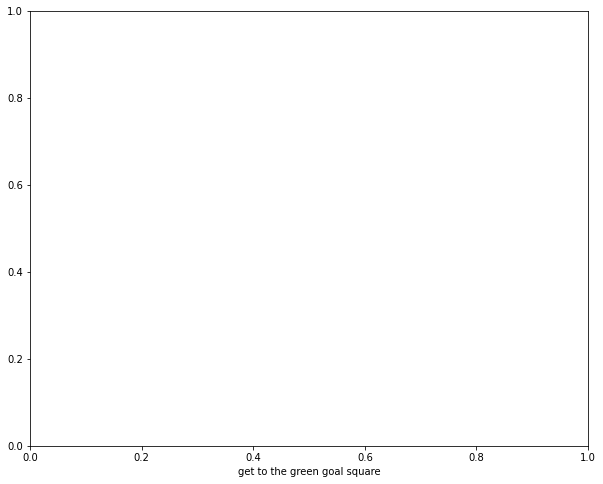

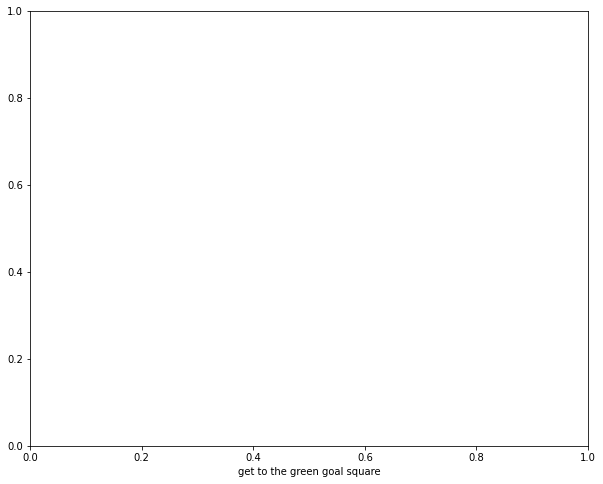

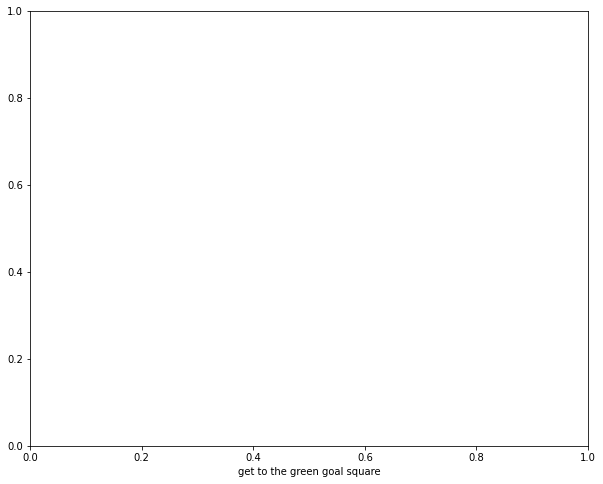

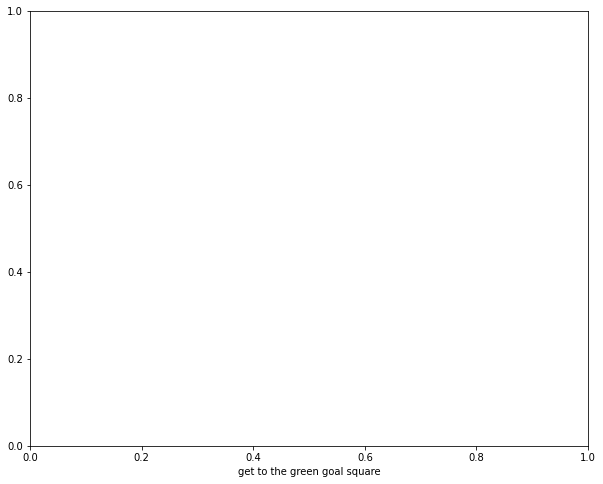

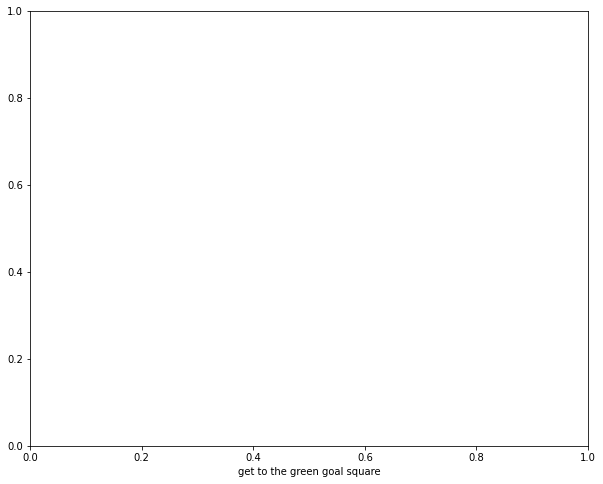

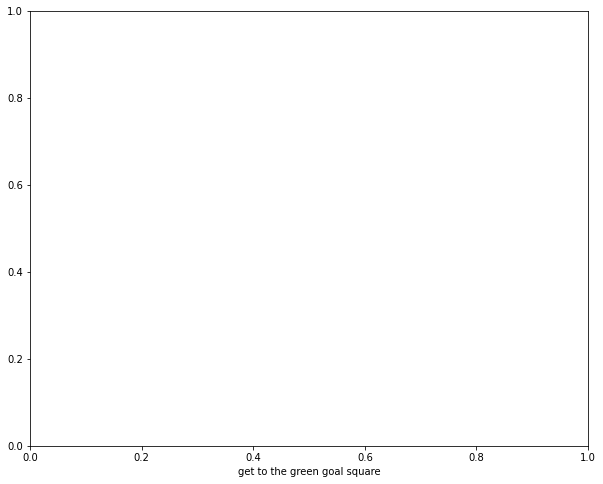

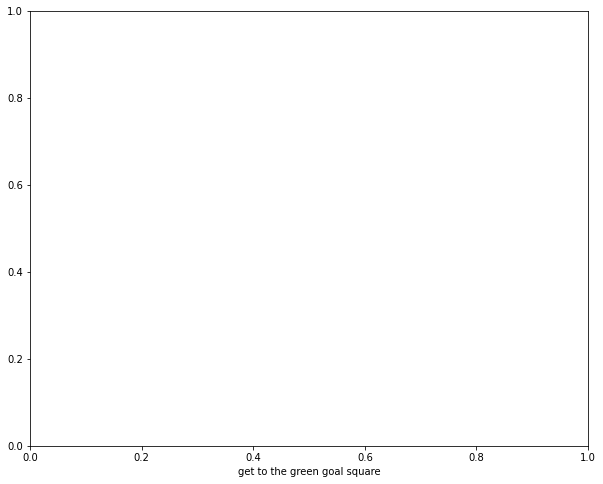

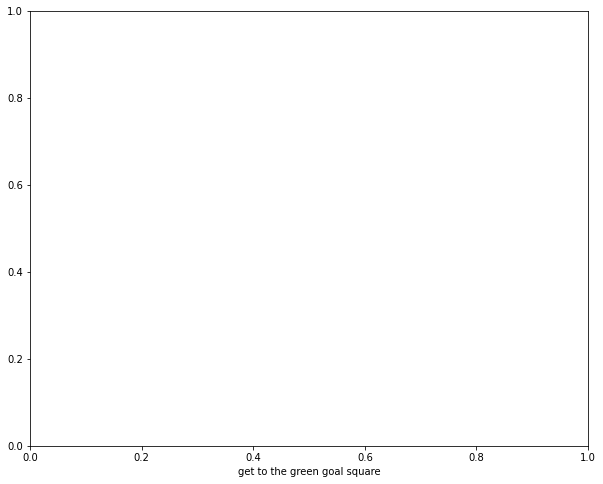

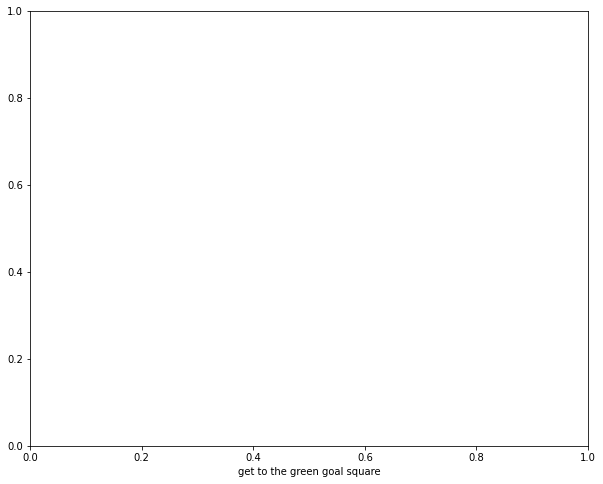

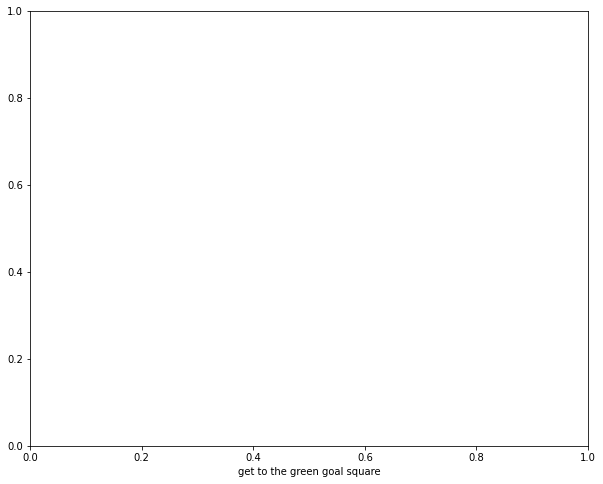

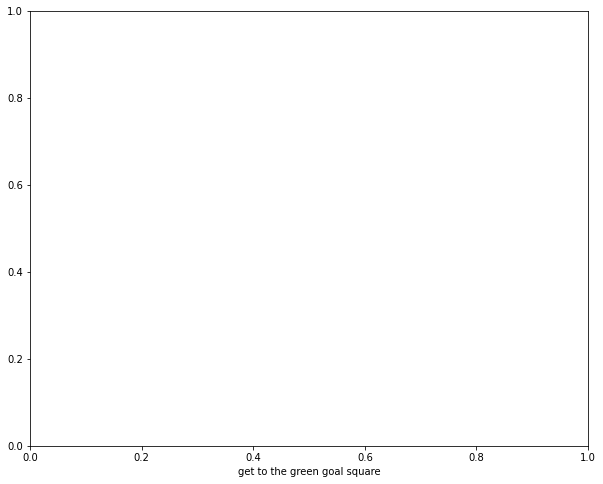

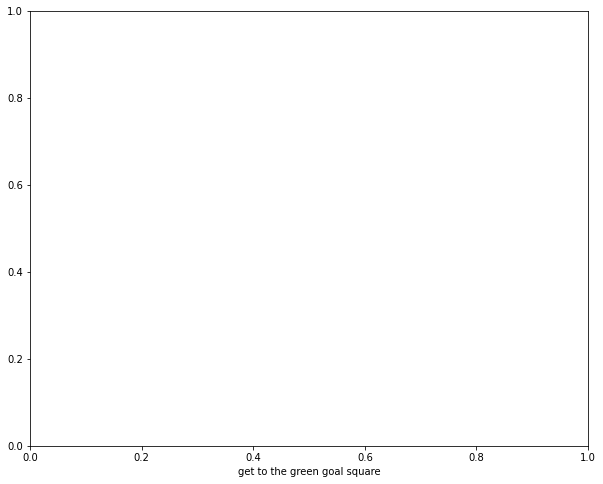

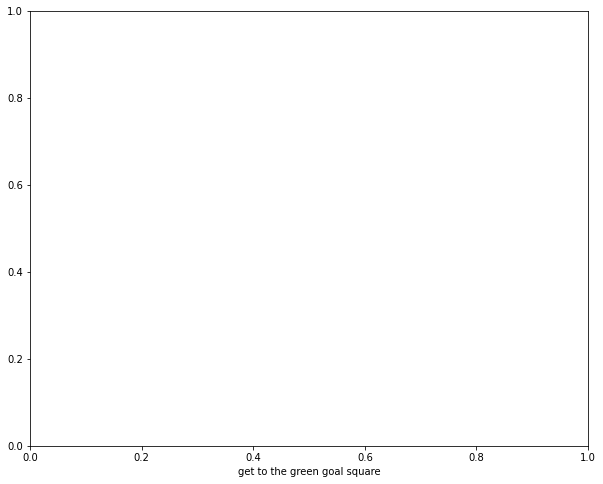

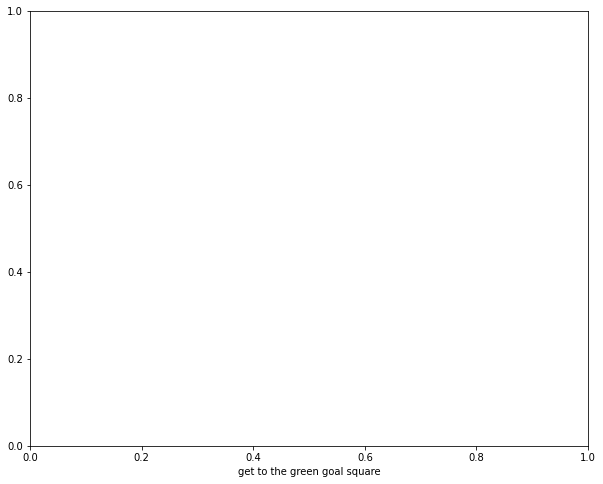

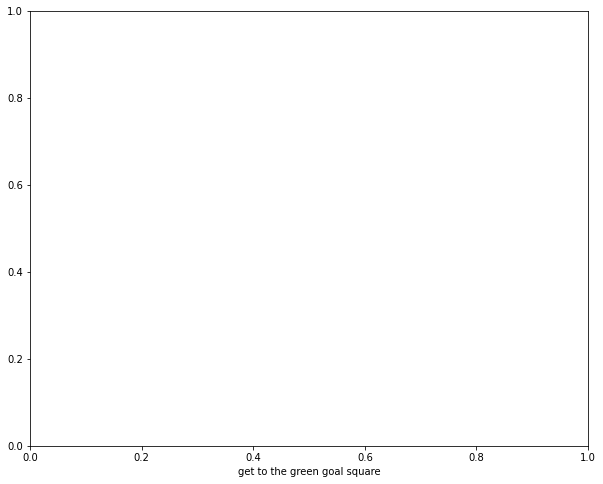

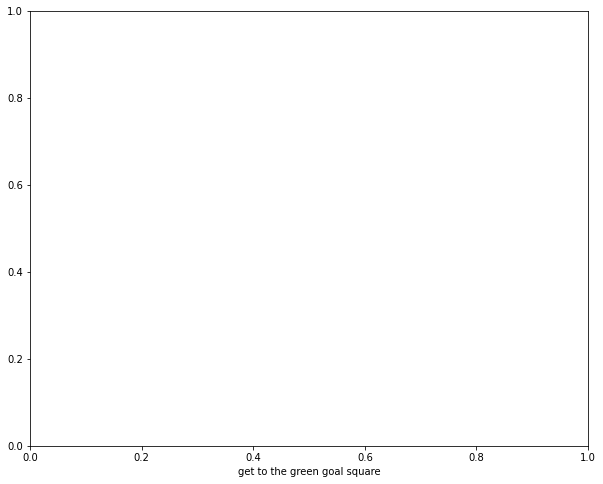

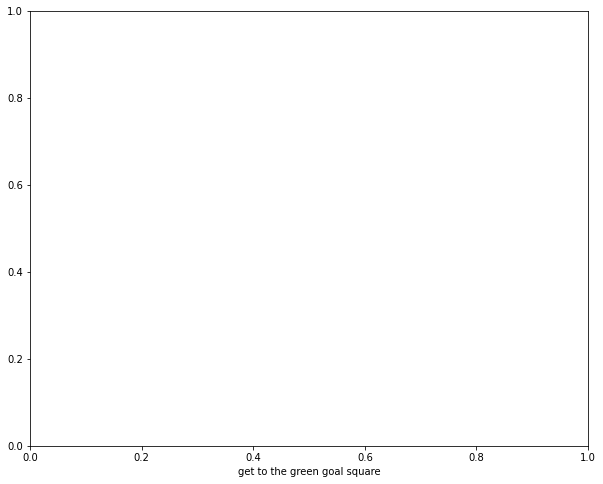

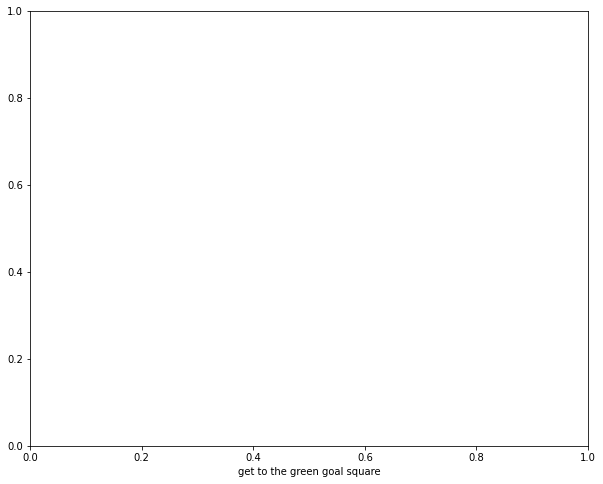

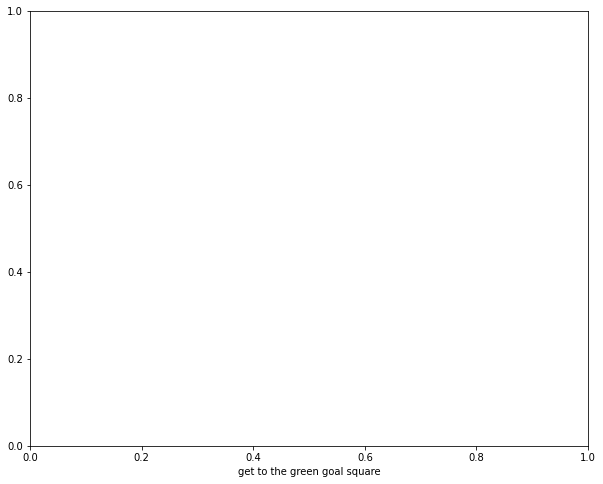

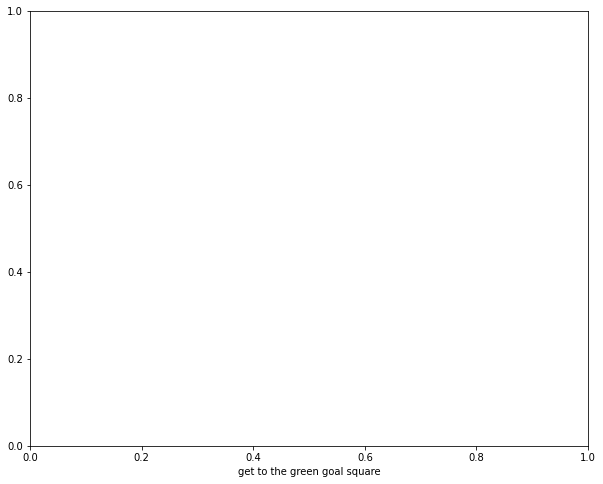

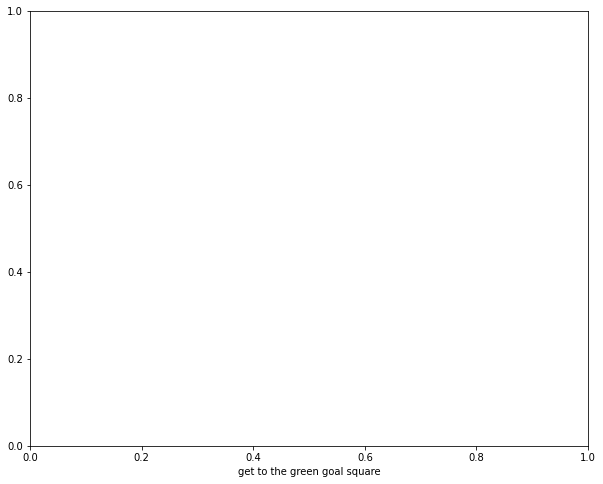

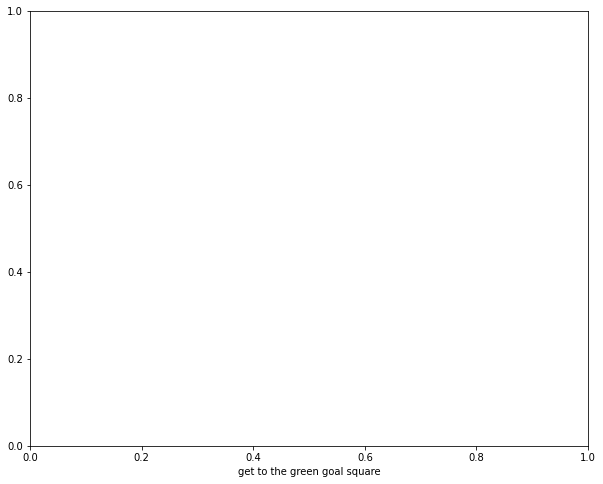

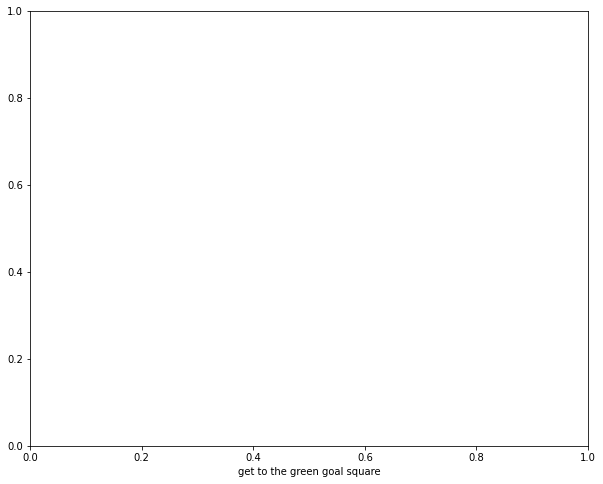

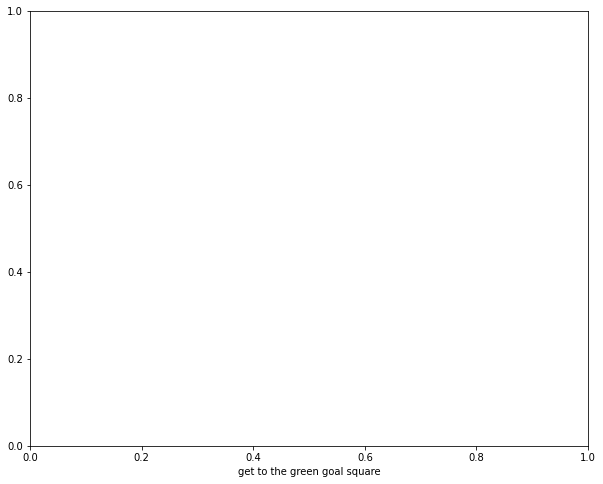

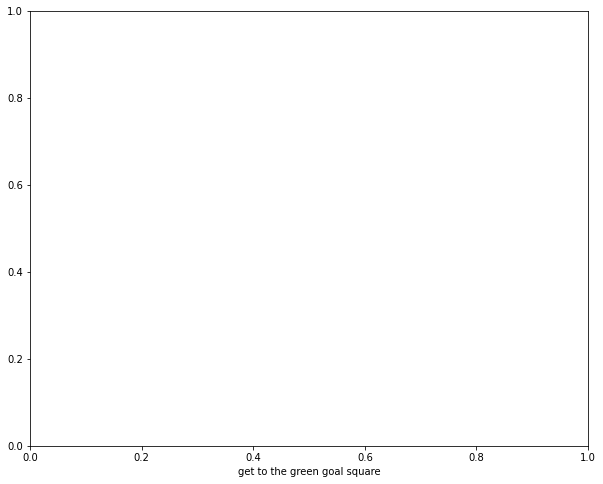

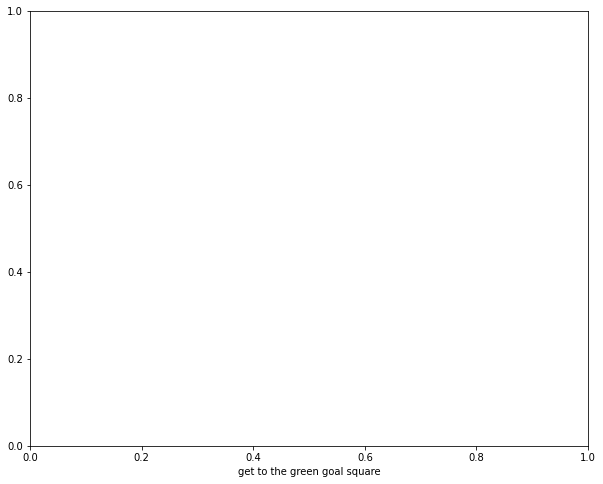

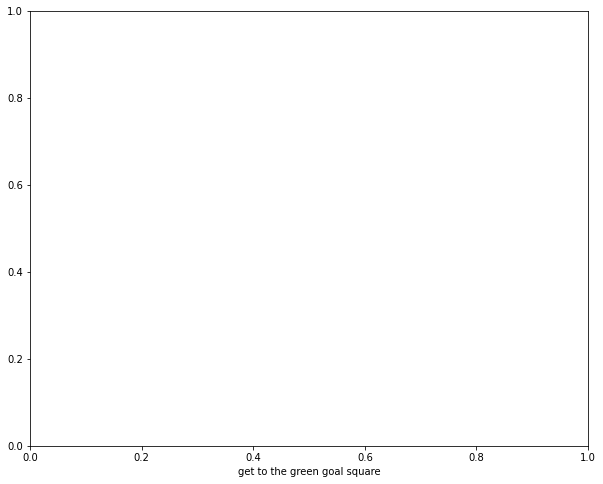

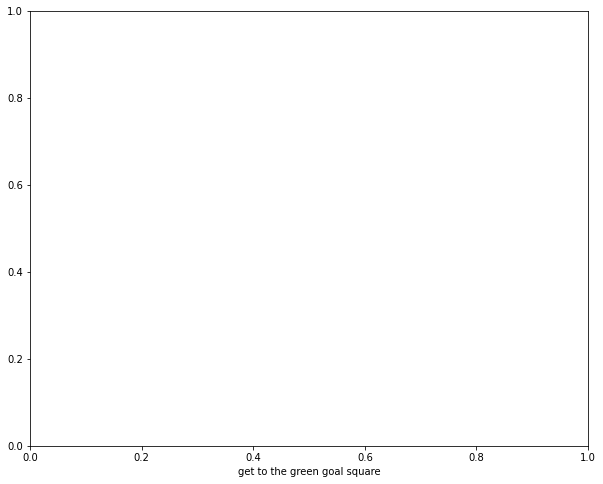

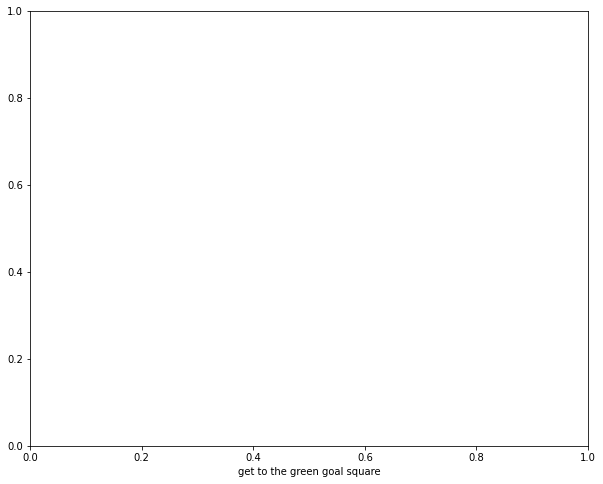

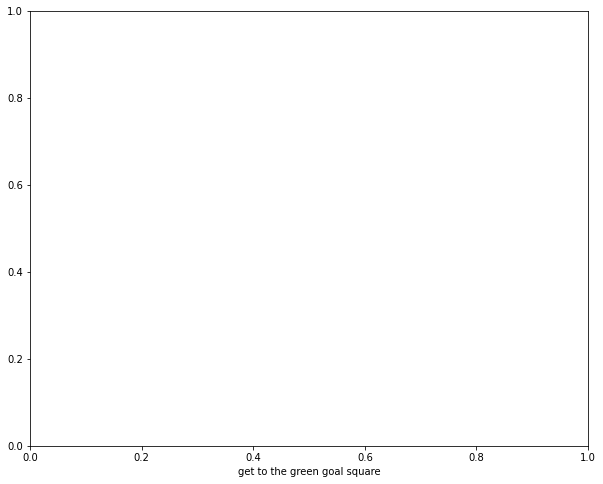

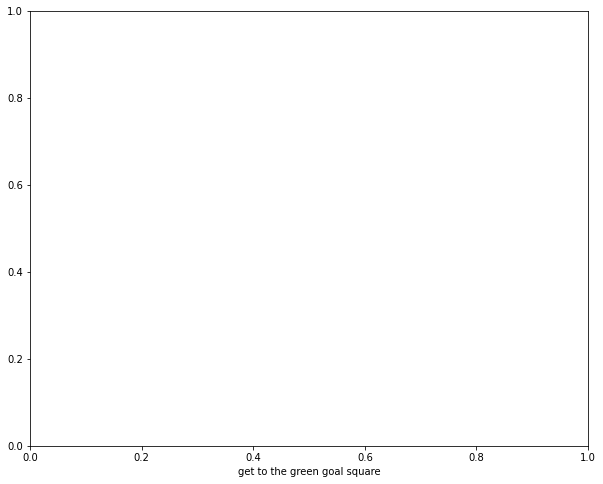

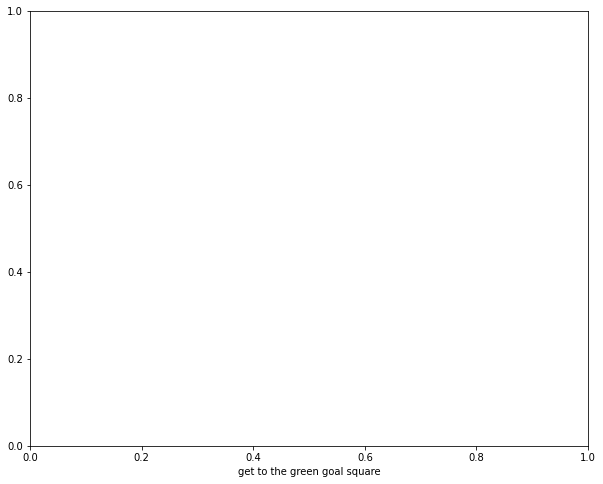

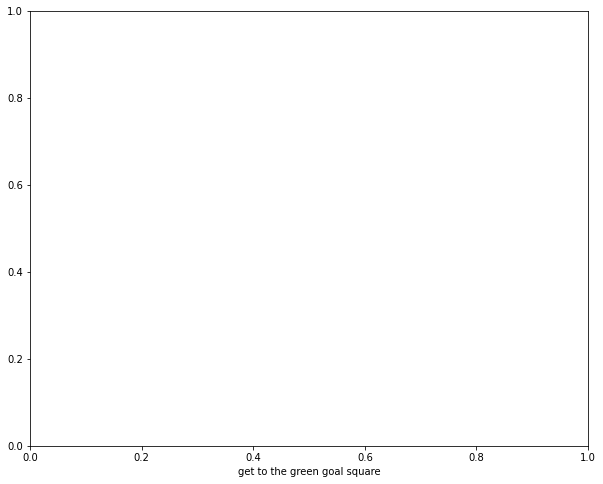

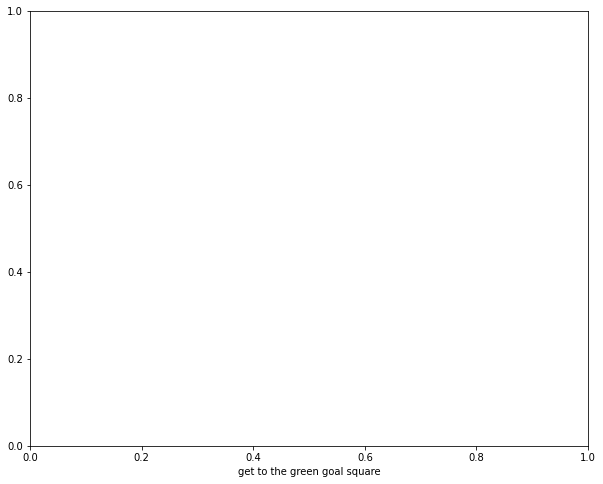

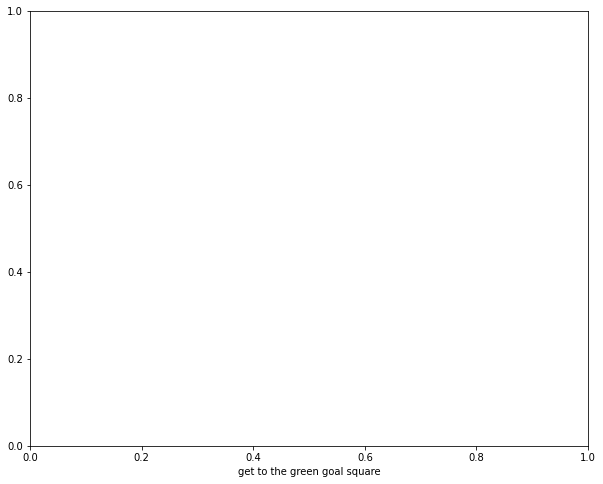

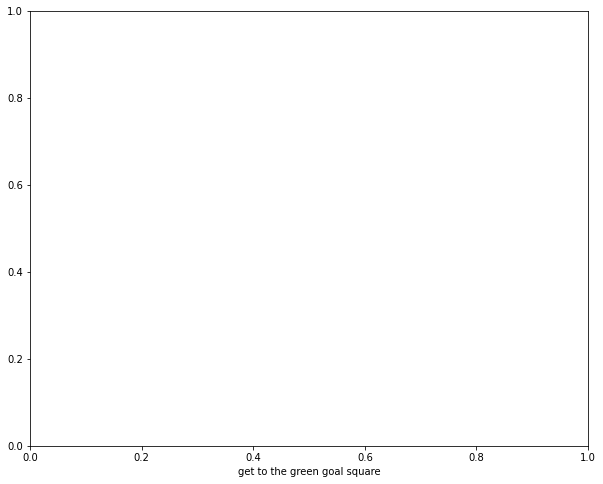

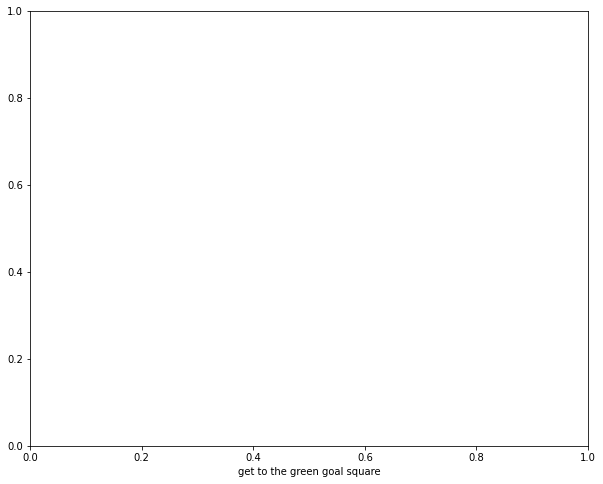

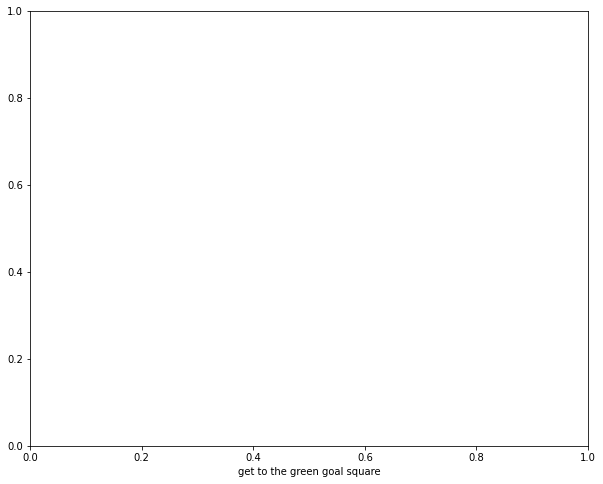

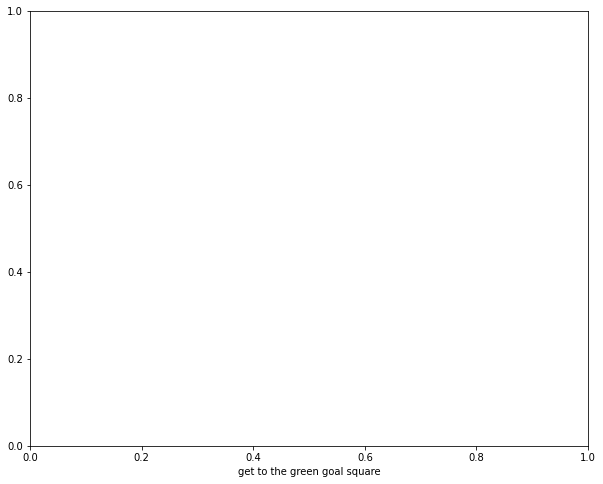

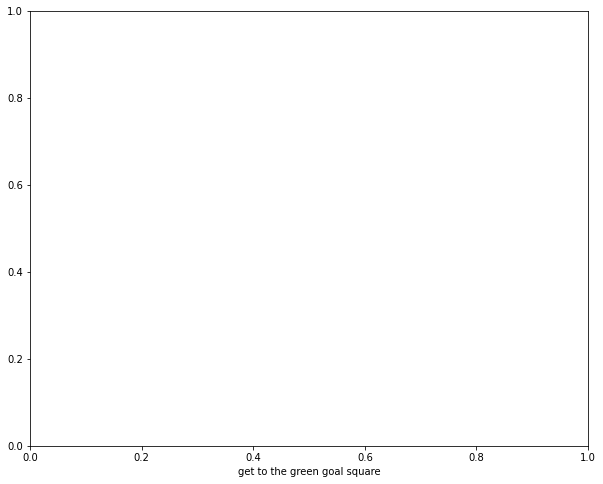

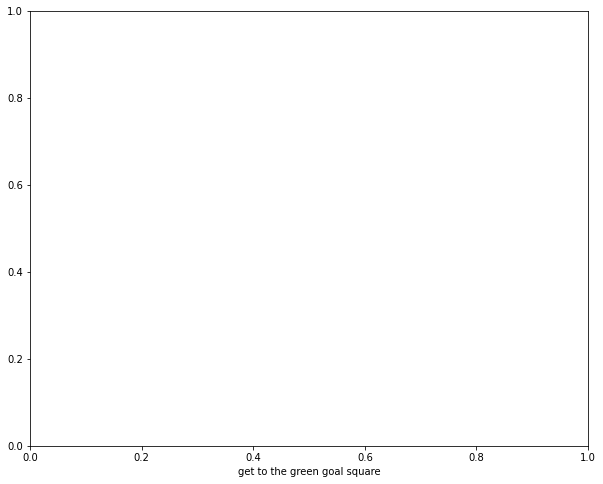

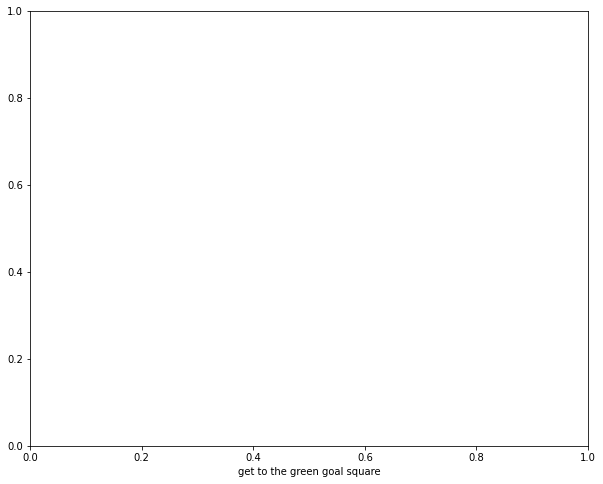

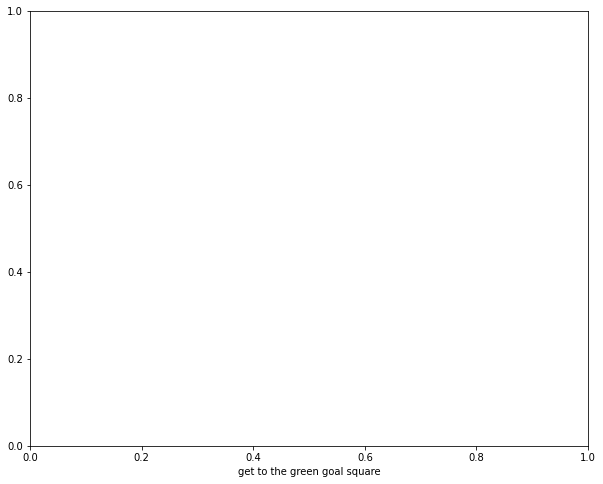

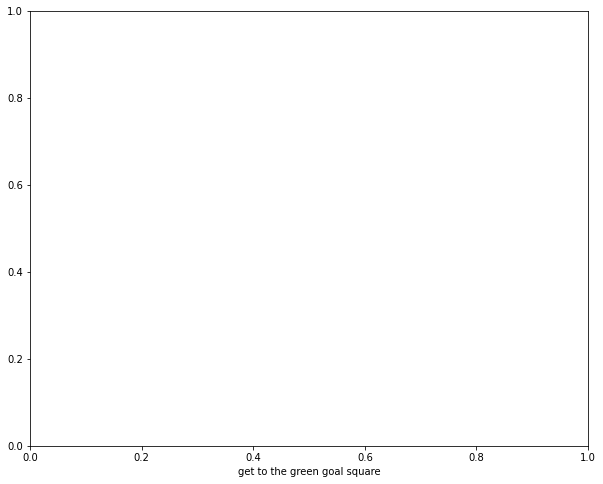

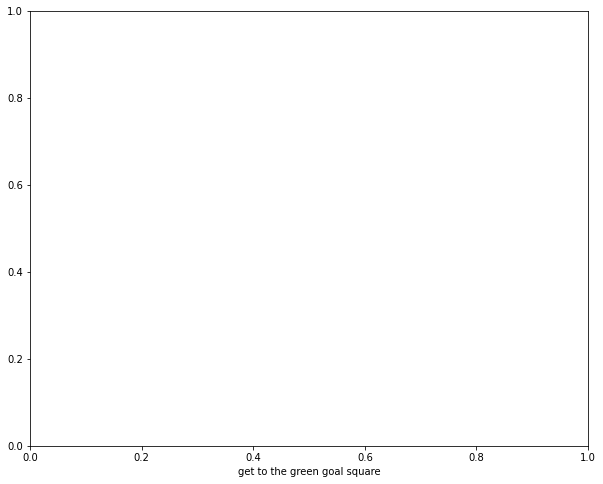

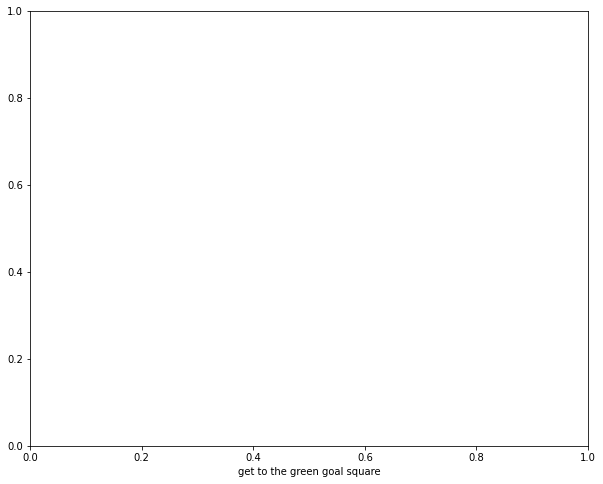

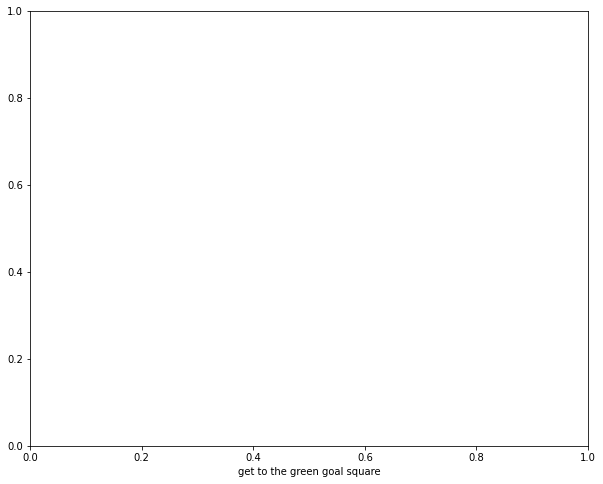

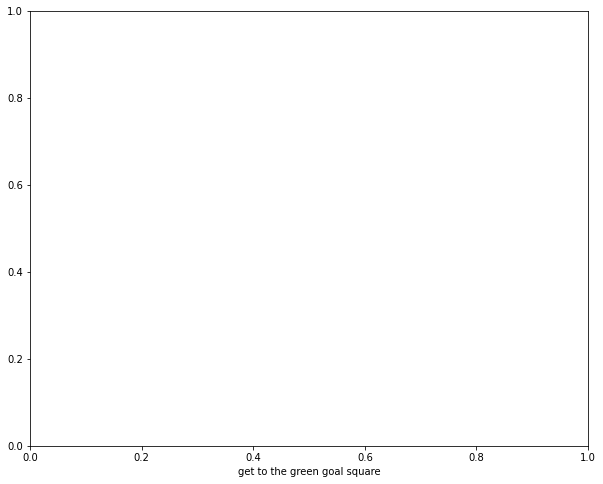

Episode 1: reward: 0.000, steps: 50


In [35]:
# env = gym.make('MiniGrid-Empty-8x8-v0')
mon = gym.wrappers.Monitor(env,"./gym-results2",force=True)
mon.reset()
dqn.test(mon, nb_episodes=1, visualize=True)
mon.close()
env.close()

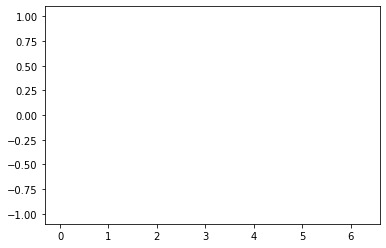

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "html5"
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
l, = ax.plot([0,2*np.pi],[-1,1])

animate = lambda i: l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t));
ani

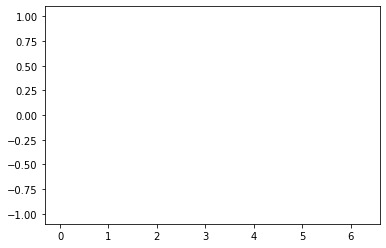

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
l, = ax.plot([0,2*np.pi],[-1,1])

animate = lambda i: l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

from IPython.display import HTML
HTML(ani.to_html5_video())